In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import pathlib
import pickle
import statsmodels
import itertools
import time

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from statistics import mode
from itertools import product
from scipy.stats import skew, kurtosis, ttest_rel
from scipy.signal import butter, welch, filtfilt, resample
from scipy import interp, stats

from sklearn.metrics import confusion_matrix, auc, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold, StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_curve, roc_auc_score

from PreprocessFcns import *

%matplotlib inline

sns.set_context('poster',font_scale=1)

In [3]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            
            ######
            
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)

#             f, t, th = roc_curve(yte,yscore)
#             print(auroc,auc(f,t))

            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d,prec=%.3f,rec=%.3f,Spec=%.3f,auroc_train=%.3f,auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres

def LOSOCV_Multi(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)

            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            
            ######
            
            yscore = clf.predict_proba(Xte)
            if len(np.unique(yte))>1:
                yte_bin = label_binarize(yte, clf.classes_)
                for c in list(range(yte_bin.shape[1]))[::-1]:
                    if not any(yte_bin[:,c]):
                        yte_bin = np.delete(yte_bin,[c],axis=1)
                        yscore = np.delete(yscore,[c],axis=1)
                        
                auroc = roc_auc_score(yte_bin,yscore,average='weighted')
                fpr_mean = np.array(range(0,101))/100
                tprs = []
                for i in range(yte_bin.shape[1]):
                    yt = yte_bin[:,i]
                    ys = yscore[:,i]
                    
#                     fpr=np.linspace(0,1,101); tpr=[]
# 
#                     if len(np.unique(yte))>1:                
#                         nscores = np.sort(np.column_stack((ys[yt==0],yt[yt==0])),axis=0)
#                         neg_counts = sum(yt==0)
#                         for f in fpr:
#                             ind = neg_counts-int(neg_counts*f)-1
#                             t = (nscores[ind])[0]
#                             print(t)
#                             if f==1:
#                                 t = 0
#                             tpr_t = sum(ys[yt==1]>t) / sum(yt==1)
#                             tpr.append(tpr_t) 

#                     print(auc(fpr,tpr),roc_auc_score(yt,ys))
#                     print(fpr, tpr)
                            
#                     fpr = np.asarray(fpr); tpr = np.asarray(tpr)*np.mean(yt)
#                     fpr_all.append(fpr); tpr_all.append(tpr)
                    
                    
                    
                    fpr, tpr, thresh = roc_curve(yte_bin[:,i],yscore[:,i],pos_label=1)
#                     print(min(yscore[yte_bin[:,i]==1,i]),max(yscore[yte_bin[:,i]==0,i]))
#                     print(fpr,tpr,thresh)
#                     print(auc(fpr,tpr),roc_auc_score(yte_bin[:,i],yscore[:,i]))
                    tprs.append(interp(fpr_mean,fpr,tpr)*np.mean(yte_bin[:,i]))
                tpr = sum(tprs)
#                 print(tpr)
                fpr = fpr_mean
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
                fpr = np.array([])
                tpr = np.array([])
            
            tpr_all.append(tpr)
            fpr_all.append(fpr)
            auroc_all.append(auroc)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d,auroc=%.3f'%(s,auroc))
            s+=1

        print('auroc=%.3f+/-%.3f'%(np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'tpr':tpr_all, 'fpr':fpr_all, 'auroc': auroc_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'auroc':np.nanmean(auroc_all)},index=[0])
        results = pd.concat((results,r))
        
        
    return results,groupres

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None,ls='-',lw=3):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=lw,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=lw,linestyle=ls)
    
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

# Accelerometer and Gyroscope Comparisons

## Tremor

In [84]:
# filename = 'Features_AllLocsHP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'
# # Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Dataorig = Dataorig.reset_index(drop=True)

Dataorig = pd.read_csv('Accel+Gyro Data 62.5Hz.csv',index_col = 0)
# Dataorig.drop(columns=['Sen_X acc', 'Sen_Y acc', 'Sen_Z acc', 'Sen_mag acc', 'Sen_X gyr', 'Sen_Y gyr', 'Sen_Z gyr', 'Sen_mag gyr'], inplace=True)
Dataorig = Dataorig.reset_index(drop=True)

In [6]:
#LOSO Accelerometer Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:79].as_matrix()
fnames = Data.iloc[:,5:79].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Accel = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Tremor 4302/16445 = 0.26
Training Random Forest

Subj/Visit 0,prec=0.188,rec=0.293,Spec=0.895,auroc_train=1.000,auroc=0.713

Subj/Visit 1,prec=0.655,rec=0.112,Spec=0.963,auroc_train=1.000,auroc=0.725

Subj/Visit 2,prec=0.670,rec=0.332,Spec=0.967,auroc_train=1.000,auroc=0.843

Subj/Visit 3,prec=0.232,rec=0.568,Spec=0.879,auroc_train=1.000,auroc=0.784

Subj/Visit 4,prec=0.464,rec=0.211,Spec=0.889,auroc_train=1.000,auroc=0.725

Subj/Visit 5,prec=0.689,rec=0.386,Spec=0.857,auroc_train=1.000,auroc=0.729

Subj/Visit 6,prec=0.728,rec=0.604,Spec=0.977,auroc_train=1.000,auroc=0.932

Subj/Visit 7,prec=0.627,rec=0.474,Spec=0.985,auroc_train=1.000,auroc=0.930

Subj/Visit 8,prec=0.916,rec=0.603,Spec=0.942,auroc_train=1.000,auroc=0.878


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9,prec=0.000,rec=0.000,Spec=0.882,auroc_train=1.000,auroc=nan

Subj/Visit 10,prec=0.185,rec=0.024,Spec=0.915,auroc_train=1.000,auroc=0.273

Subj/Visit 11,prec=0.949,rec=0.564,Spec=0.890,auroc_train=1.000,auroc=0.852

Subj/Visit 12,prec=0.014,rec=0.286,Spec=0.877,auroc_train=1.000,auroc=0.827
f1_test=0.360+/-0.247, prec=0.486+/-0.314, rec=0.343+/-0.206, auprc=0.502+/-0.270, auroc=0.768+/-0.167
Elapsed time = 1.353 min


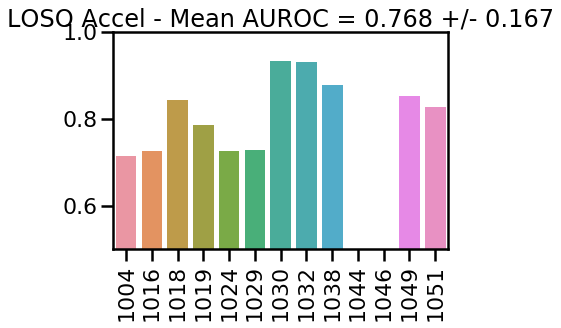

In [7]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOAccel_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.5,1.0])
plt.title('LOSO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOAccel_Hand.png',format='png',dpi=1000)

In [8]:
#LOSO Gyroscope Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,79:].as_matrix()
fnames = Data.iloc[:,79:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Gyro = res_group['Random Forest']

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Tremor 4302/16445 = 0.26
Training Random Forest

Subj/Visit 0,prec=0.151,rec=0.348,Spec=0.839,auroc_train=1.000,auroc=0.716

Subj/Visit 1,prec=0.750,rec=0.177,Spec=0.963,auroc_train=1.000,auroc=0.792

Subj/Visit 2,prec=0.686,rec=0.411,Spec=0.962,auroc_train=1.000,auroc=0.782

Subj/Visit 3,prec=0.248,rec=0.473,Spec=0.908,auroc_train=1.000,auroc=0.784

Subj/Visit 4,prec=0.533,rec=0.185,Spec=0.926,auroc_train=1.000,auroc=0.721

Subj/Visit 5,prec=0.729,rec=0.415,Spec=0.873,auroc_train=1.000,auroc=0.774

Subj/Visit 6,prec=0.721,rec=0.721,Spec=0.971,auroc_train=1.000,auroc=0.935

Subj/Visit 7,prec=0.581,rec=0.641,Spec=0.976,auroc_train=1.000,auroc=0.914

Subj/Visit 8,prec=0.908,rec=0.544,Spec=0.942,auroc_train=1.000,auroc=0.881


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9,prec=0.000,rec=0.000,Spec=0.849,auroc_train=1.000,auroc=nan

Subj/Visit 10,prec=0.716,rec=0.147,Spec=0.953,auroc_train=1.000,auroc=0.597

Subj/Visit 11,prec=0.942,rec=0.608,Spec=0.863,auroc_train=1.000,auroc=0.846

Subj/Visit 12,prec=0.011,rec=0.286,Spec=0.843,auroc_train=1.000,auroc=0.773
f1_test=0.397+/-0.243, prec=0.537+/-0.313, rec=0.381+/-0.208, auprc=0.572+/-0.260, auroc=0.793+/-0.089
Elapsed time = 1.431 min


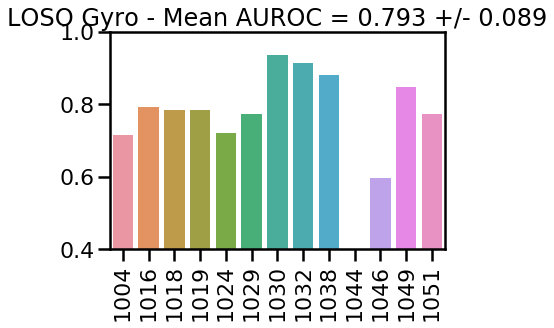

In [9]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOGyro_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.4,1.0])
plt.title('LOSO Gyro - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOGyro_Hand.png',format='png',dpi=1000)

In [10]:
#LOSO Combined Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
fnames = Data.iloc[:,5:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Comb = res_group['Random Forest']

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Tremor 4302/16445 = 0.26
Training Random Forest

Subj/Visit 0,prec=0.207,rec=0.326,Spec=0.897,auroc_train=1.000,auroc=0.750

Subj/Visit 1,prec=0.708,rec=0.153,Spec=0.961,auroc_train=1.000,auroc=0.760

Subj/Visit 2,prec=0.684,rec=0.396,Spec=0.963,auroc_train=1.000,auroc=0.827

Subj/Visit 3,prec=0.273,rec=0.554,Spec=0.905,auroc_train=1.000,auroc=0.808

Subj/Visit 4,prec=0.517,rec=0.190,Spec=0.919,auroc_train=1.000,auroc=0.723

Subj/Visit 5,prec=0.694,rec=0.424,Spec=0.846,auroc_train=1.000,auroc=0.755

Subj/Visit 6,prec=0.871,rec=0.793,Spec=0.988,auroc_train=1.000,auroc=0.947

Subj/Visit 7,prec=0.632,rec=0.615,Spec=0.981,auroc_train=1.000,auroc=0.927

Subj/Visit 8,prec=0.915,rec=0.566,Spec=0.945,auroc_train=1.000,auroc=0.879


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9,prec=0.000,rec=0.000,Spec=0.871,auroc_train=1.000,auroc=nan

Subj/Visit 10,prec=0.286,rec=0.028,Spec=0.944,auroc_train=1.000,auroc=0.415

Subj/Visit 11,prec=0.944,rec=0.606,Spec=0.870,auroc_train=1.000,auroc=0.860

Subj/Visit 12,prec=0.012,rec=0.286,Spec=0.850,auroc_train=1.000,auroc=0.716
f1_test=0.396+/-0.270, prec=0.519+/-0.317, rec=0.380+/-0.234, auprc=0.556+/-0.270, auroc=0.781+/-0.133
Elapsed time = 2.039 min


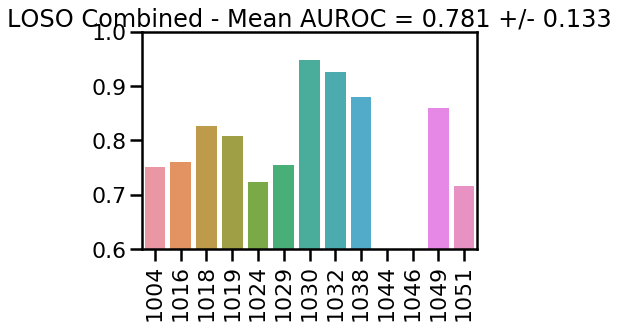

In [11]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOCombined_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.60,1.0])
plt.title('LOSO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOCombined_Hand.png',format='png',dpi=1000)

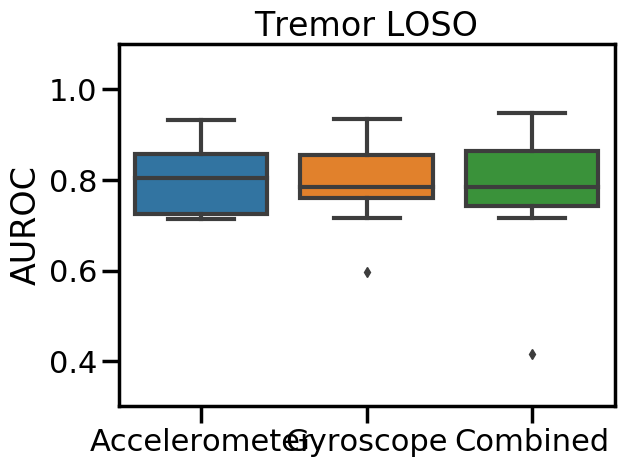

In [12]:
resultsAccel = np.load('Results/resultsTremorLOSOAccel_Hand.npy')
resultsGyro = np.load('Results/resultsTremorLOSOGyro_Hand.npy')
resultsCombined = np.load('Results/resultsTremorLOSOCombined_Hand.npy')
results = pd.DataFrame({'Accelerometer':resultsAccel,'Gyroscope':resultsGyro,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Tremor LOSO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Tremor Comparison Boxplot LOSO Hand.png',format='png',dpi=1000)

## Bradykinesia

In [13]:
# filename = 'Features_AllLocsHP+LP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'
# Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Dataorig = Dataorig.reset_index(drop=True)

Dataorig = pd.read_csv('Accel+Gyro Data 62.5Hz.csv', index_col = 0)
# Dataorig.drop(columns=['Sen_X acc', 'Sen_Y acc', 'Sen_Z acc', 'Sen_mag acc', 'Sen_X gyr', 'Sen_Y gyr', 'Sen_Z gyr', 'Sen_mag gyr'], inplace=True)
Dataorig = Dataorig.reset_index(drop=True)

In [14]:
#LOSO Accelerometer Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:79].as_matrix()
fnames = Data.iloc[:,5:79].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Accel = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Bradykinesia 6697/12184 = 0.55
Training Random Forest

Subj/Visit 0,prec=0.289,rec=0.491,Spec=0.551,auroc_train=1.000,auroc=0.533

Subj/Visit 1,prec=0.921,rec=0.748,Spec=0.649,auroc_train=1.000,auroc=0.758

Subj/Visit 2,prec=0.927,rec=0.809,Spec=0.652,auroc_train=1.000,auroc=0.764

Subj/Visit 3,prec=0.597,rec=0.898,Spec=0.277,auroc_train=1.000,auroc=0.567

Subj/Visit 4,prec=0.802,rec=0.699,Spec=0.734,auroc_train=1.000,auroc=0.761

Subj/Visit 5,prec=0.745,rec=0.630,Spec=0.696,auroc_train=1.000,auroc=0.711

Subj/Visit 6,prec=0.756,rec=0.947,Spec=0.418,auroc_train=1.000,auroc=0.740

Subj/Visit 7,prec=0.819,rec=0.632,Spec=0.489,auroc_train=1.000,auroc=0.555

Subj/Visit 8,prec=0.070,rec=0.582,Spec=0.337,auroc_train=1.000,auroc=0.460

Subj/Visit 9,prec=0.079,rec=0.837,Spec=0.462,auroc_train=1.000,auroc=0.706

Subj/Visit 10,prec=0.496,rec=0.409,Spec=0.489,auroc_train=1.000,auroc=0.450

Subj/Visit 11,prec=0.894,rec=0.439,Spec=0.623,auroc_train=1.000,auroc=0.522

Subj/Visit 12,prec=0.418

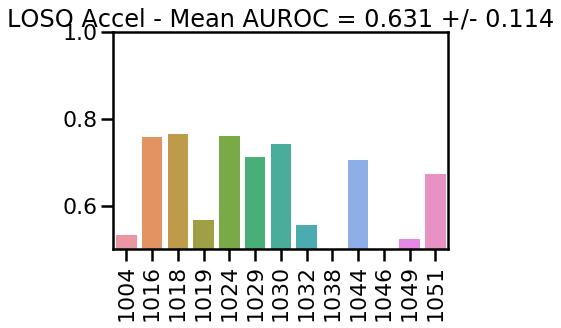

In [15]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOAccel_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.5,1.0])
plt.title('LOSO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOAccel_Hand.png',format='png',dpi=1000)

In [16]:
#LOSO Gyroscope Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,79:].as_matrix()
fnames = Data.iloc[:,79:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Gyro = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Bradykinesia 6697/12184 = 0.55
Training Random Forest

Subj/Visit 0,prec=0.360,rec=0.748,Spec=0.506,auroc_train=1.000,auroc=0.664

Subj/Visit 1,prec=0.943,rec=0.752,Spec=0.750,auroc_train=1.000,auroc=0.827

Subj/Visit 2,prec=0.939,rec=0.878,Spec=0.688,auroc_train=1.000,auroc=0.846

Subj/Visit 3,prec=0.606,rec=0.942,Spec=0.270,auroc_train=1.000,auroc=0.598

Subj/Visit 4,prec=0.756,rec=0.613,Spec=0.695,auroc_train=1.000,auroc=0.730

Subj/Visit 5,prec=0.691,rec=0.638,Spec=0.600,auroc_train=1.000,auroc=0.628

Subj/Visit 6,prec=0.750,rec=0.926,Spec=0.414,auroc_train=1.000,auroc=0.775

Subj/Visit 7,prec=0.928,rec=0.669,Spec=0.809,auroc_train=1.000,auroc=0.786

Subj/Visit 8,prec=0.072,rec=0.557,Spec=0.384,auroc_train=1.000,auroc=0.466

Subj/Visit 9,prec=0.091,rec=0.959,Spec=0.465,auroc_train=1.000,auroc=0.800

Subj/Visit 10,prec=0.633,rec=0.595,Spec=0.577,auroc_train=1.000,auroc=0.603

Subj/Visit 11,prec=0.868,rec=0.447,Spec=0.508,auroc_train=1.000,auroc=0.500

Subj/Visit 12,prec=0.379

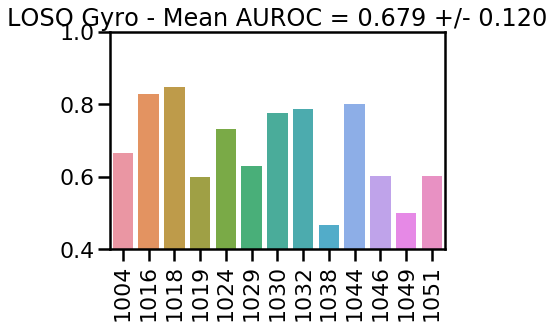

In [17]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOGyro_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.4,1.0])
plt.title('LOSO Gyro - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOGyro_Hand.png',format='png',dpi=1000)

In [18]:
#LOSO Combined Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
fnames = Data.iloc[:,5:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Comb = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Bradykinesia 6697/12184 = 0.55
Training Random Forest

Subj/Visit 0,prec=0.382,rec=0.806,Spec=0.514,auroc_train=1.000,auroc=0.696

Subj/Visit 1,prec=0.921,rec=0.794,Spec=0.628,auroc_train=1.000,auroc=0.796

Subj/Visit 2,prec=0.940,rec=0.867,Spec=0.696,auroc_train=1.000,auroc=0.815

Subj/Visit 3,prec=0.611,rec=0.956,Spec=0.274,auroc_train=1.000,auroc=0.586

Subj/Visit 4,prec=0.813,rec=0.658,Spec=0.766,auroc_train=1.000,auroc=0.783

Subj/Visit 5,prec=0.744,rec=0.648,Spec=0.687,auroc_train=1.000,auroc=0.675

Subj/Visit 6,prec=0.750,rec=0.940,Spec=0.404,auroc_train=1.000,auroc=0.787

Subj/Visit 7,prec=0.830,rec=0.707,Spec=0.469,auroc_train=1.000,auroc=0.636

Subj/Visit 8,prec=0.075,rec=0.570,Spec=0.397,auroc_train=1.000,auroc=0.488

Subj/Visit 9,prec=0.095,rec=1.000,Spec=0.469,auroc_train=1.000,auroc=0.792

Subj/Visit 10,prec=0.579,rec=0.508,Spec=0.547,auroc_train=1.000,auroc=0.549

Subj/Visit 11,prec=0.884,rec=0.412,Spec=0.607,auroc_train=1.000,auroc=0.497

Subj/Visit 12,prec=0.405

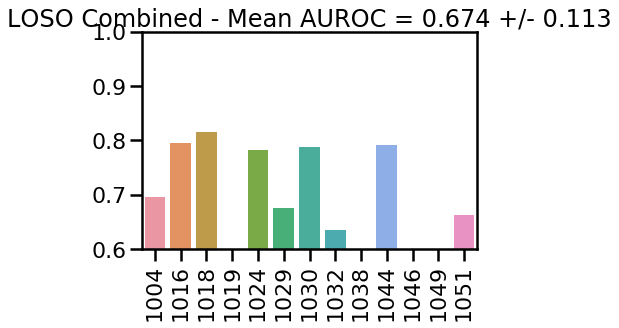

In [19]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOCombined_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.60,1.0])
plt.title('LOSO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOCombined_Hand.png',format='png',dpi=1000)

# Smartwatch Comparisons

## Tremor

In [21]:
#Hand Sensors

# filename = 'Features_AllLocsHP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'

# Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Dataorig = Dataorig.reset_index(drop=True)

Dataorig = pd.read_csv('Accel+Gyro Data 62.5Hz.csv', index_col = 0)

Dataorig=Dataorig[Dataorig.Subject!=1020]
Dataorig = Dataorig.iloc[:,:79]
Dataorig = Dataorig.loc[(Dataorig.Subject==1004) | 
                        (Dataorig.Subject==1016) | 
                        (Dataorig.Subject==1018) | 
                        (Dataorig.Subject==1019) | 
#                        (Dataorig.Subject==1020) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1024) | 
                        (Dataorig.Subject==1029) | 
                        (Dataorig.Subject==1030) | 
                        (Dataorig.Subject==1032) | 
                        (Dataorig.Subject==1038) | 
                        (Dataorig.Subject==1044) | 
                        (Dataorig.Subject==1046) | 
                        (Dataorig.Subject==1049) | 
                        (Dataorig.Subject==1051)]

# Dataorig.drop(columns=['Sen_X acc', 'Sen_Y acc', 'Sen_Z acc', 'Sen_mag acc'], inplace=True)


t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Tremor 4302/16445 = 0.26
Training Random Forest

Subj/Visit 0,prec=0.163,rec=0.239,Spec=0.899,auroc_train=1.000,auroc=0.711

Subj/Visit 1,prec=0.658,rec=0.106,Spec=0.966,auroc_train=1.000,auroc=0.714

Subj/Visit 2,prec=0.683,rec=0.342,Spec=0.968,auroc_train=1.000,auroc=0.840

Subj/Visit 3,prec=0.220,rec=0.541,Spec=0.876,auroc_train=1.000,auroc=0.774

Subj/Visit 4,prec=0.531,rec=0.241,Spec=0.903,auroc_train=1.000,auroc=0.720

Subj/Visit 5,prec=0.685,rec=0.368,Spec=0.861,auroc_train=1.000,auroc=0.739

Subj/Visit 6,prec=0.720,rec=0.604,Spec=0.976,auroc_train=1.000,auroc=0.931

Subj/Visit 7,prec=0.628,rec=0.346,Spec=0.989,auroc_train=1.000,auroc=0.909

Subj/Visit 8,prec=0.923,rec=0.610,Spec=0.946,auroc_train=1.000,auroc=0.879


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9,prec=0.000,rec=0.000,Spec=0.891,auroc_train=1.000,auroc=nan

Subj/Visit 10,prec=0.250,rec=0.024,Spec=0.942,auroc_train=1.000,auroc=0.304

Subj/Visit 11,prec=0.950,rec=0.570,Spec=0.890,auroc_train=1.000,auroc=0.855

Subj/Visit 12,prec=0.000,rec=0.000,Spec=0.875,auroc_train=1.000,auroc=0.794
f1_test=0.350+/-0.249, prec=0.493+/-0.315, rec=0.307+/-0.220, auprc=0.494+/-0.271, auroc=0.764+/-0.157
Elapsed time = 1.357 min


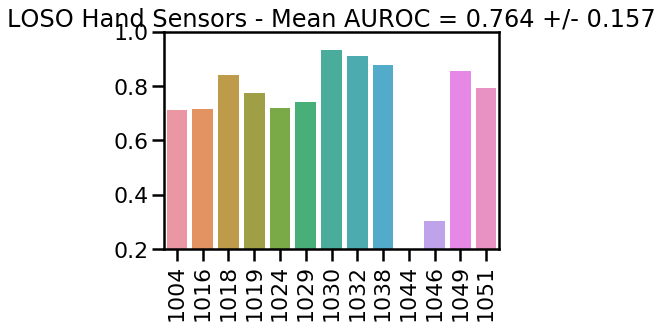

In [22]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorHand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Hand Sensors - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorHand.png',format='png',dpi=1000)

In [23]:
# Smart Watch

Dataorig = pd.read_csv('Watch Data 50Hz.csv',index_col=0)
# Dataorig.drop(columns=['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'], inplace=True)
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]
# Dataorig=Dataorig[Dataorig.Subject!=1030]

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,5:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Watch = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Tremor 3755/14160 = 0.27
Training Random Forest

Subj/Visit 0,prec=0.236,rec=0.484,Spec=0.845,auroc_train=1.000,auroc=0.736

Subj/Visit 1,prec=0.789,rec=0.204,Spec=0.968,auroc_train=1.000,auroc=0.800

Subj/Visit 2,prec=0.678,rec=0.323,Spec=0.970,auroc_train=1.000,auroc=0.859

Subj/Visit 3,prec=0.284,rec=0.403,Spec=0.934,auroc_train=1.000,auroc=0.769

Subj/Visit 4,prec=0.650,rec=0.266,Spec=0.927,auroc_train=1.000,auroc=0.769

Subj/Visit 5,prec=0.665,rec=0.443,Spec=0.819,auroc_train=1.000,auroc=0.751

Subj/Visit 6,prec=0.765,rec=0.867,Spec=0.974,auroc_train=1.000,auroc=0.981

Subj/Visit 7,prec=0.527,rec=0.681,Spec=0.968,auroc_train=1.000,auroc=0.950

Subj/Visit 8,prec=0.941,rec=0.597,Spec=0.956,auroc_train=1.000,auroc=0.878


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9,prec=0.000,rec=0.000,Spec=0.914,auroc_train=1.000,auroc=nan

Subj/Visit 10,prec=0.286,rec=0.045,Spec=0.919,auroc_train=1.000,auroc=0.265

Subj/Visit 11,prec=0.944,rec=0.648,Spec=0.868,auroc_train=1.000,auroc=0.880

Subj/Visit 12,prec=0.019,rec=0.286,Spec=0.905,auroc_train=1.000,auroc=0.846
f1_test=0.411+/-0.261, prec=0.522+/-0.312, rec=0.403+/-0.243, auprc=0.551+/-0.275, auroc=0.790+/-0.175
Elapsed time = 1.112 min


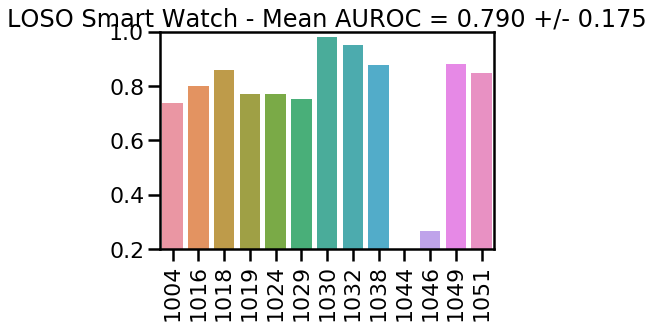

In [24]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorWatch.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Smart Watch - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorWatch.png',format='png',dpi=1000)

## Bradykinesia

In [26]:
#Hand Sensors

# filename = 'Features_AllLocsHP+LP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'

# Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
Dataorig = pd.read_csv('Accel+Gyro Data 62.5Hz.csv', index_col = 0)
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]
Dataorig = Dataorig.iloc[:,:79]
Dataorig = Dataorig.loc[(Dataorig.Subject==1004) | 
                        (Dataorig.Subject==1016) | 
                        (Dataorig.Subject==1018) | 
                        (Dataorig.Subject==1019) | 
#                        (Dataorig.Subject==1020) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1024) | 
                        (Dataorig.Subject==1029) | 
                        (Dataorig.Subject==1030) | 
                        (Dataorig.Subject==1032) | 
                        (Dataorig.Subject==1038) | 
                        (Dataorig.Subject==1044) | 
                        (Dataorig.Subject==1046) | 
                        (Dataorig.Subject==1049) | 
                        (Dataorig.Subject==1051)]

# Dataorig.drop(columns=['Sen_X acc', 'Sen_Y acc', 'Sen_Z acc', 'Sen_mag acc'], inplace=True)

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))


    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Bradykinesia 6697/12184 = 0.55
Training Random Forest

Subj/Visit 0,prec=0.310,rec=0.532,Spec=0.559,auroc_train=1.000,auroc=0.539

Subj/Visit 1,prec=0.921,rec=0.736,Spec=0.655,auroc_train=1.000,auroc=0.763

Subj/Visit 2,prec=0.930,rec=0.794,Spec=0.674,auroc_train=1.000,auroc=0.760

Subj/Visit 3,prec=0.603,rec=0.926,Spec=0.274,auroc_train=1.000,auroc=0.578

Subj/Visit 4,prec=0.784,rec=0.681,Spec=0.712,auroc_train=1.000,auroc=0.753

Subj/Visit 5,prec=0.750,rec=0.623,Spec=0.708,auroc_train=1.000,auroc=0.705

Subj/Visit 6,prec=0.753,rec=0.954,Spec=0.404,auroc_train=1.000,auroc=0.748

Subj/Visit 7,prec=0.823,rec=0.625,Spec=0.508,auroc_train=1.000,auroc=0.564

Subj/Visit 8,prec=0.080,rec=0.620,Spec=0.382,auroc_train=1.000,auroc=0.485

Subj/Visit 9,prec=0.079,rec=0.898,Spec=0.421,auroc_train=1.000,auroc=0.710

Subj/Visit 10,prec=0.478,rec=0.362,Spec=0.514,auroc_train=1.000,auroc=0.443

Subj/Visit 11,prec=0.895,rec=0.426,Spec=0.639,auroc_train=1.000,auroc=0.543

Subj/Visit 12,prec=0.405

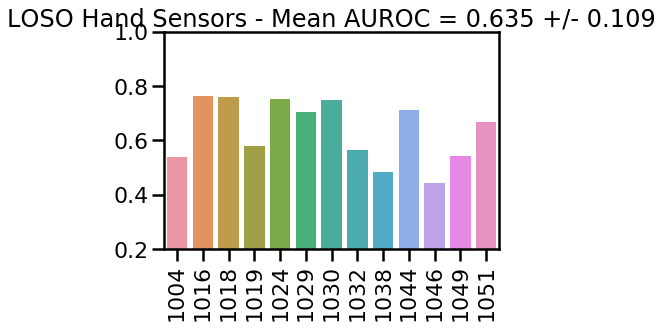

In [27]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaHand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Hand Sensors - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaHand.png',format='png',dpi=1000)

In [28]:
#Smart Watch

Dataorig = pd.read_csv('Watch Data 50Hz.csv',index_col=0)
# Dataorig.drop(columns=['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'], inplace=True)
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]
# Dataorig=Dataorig[Dataorig.Subject!=1030]

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,5:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Watch = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Rows w Bradykinesia 5906/10690 = 0.55
Training Random Forest

Subj/Visit 0,prec=0.383,rec=0.552,Spec=0.611,auroc_train=1.000,auroc=0.601

Subj/Visit 1,prec=0.925,rec=0.758,Spec=0.662,auroc_train=1.000,auroc=0.763

Subj/Visit 2,prec=0.927,rec=0.746,Spec=0.695,auroc_train=1.000,auroc=0.758

Subj/Visit 3,prec=0.625,rec=0.839,Spec=0.327,auroc_train=1.000,auroc=0.575

Subj/Visit 4,prec=0.707,rec=0.814,Spec=0.490,auroc_train=1.000,auroc=0.708

Subj/Visit 5,prec=0.737,rec=0.615,Spec=0.686,auroc_train=1.000,auroc=0.673

Subj/Visit 6,prec=0.615,rec=0.831,Spec=0.315,auroc_train=1.000,auroc=0.698

Subj/Visit 7,prec=0.824,rec=0.719,Spec=0.459,auroc_train=1.000,auroc=0.639

Subj/Visit 8,prec=0.073,rec=0.729,Spec=0.295,auroc_train=1.000,auroc=0.508

Subj/Visit 9,prec=0.082,rec=0.959,Spec=0.358,auroc_train=1.000,auroc=0.726

Subj/Visit 10,prec=0.535,rec=0.383,Spec=0.618,auroc_train=1.000,auroc=0.447

Subj/Visit 11,prec=0.919,rec=0.422,Spec=0.463,auroc_train=1.000,auroc=0.396

Subj/Visit 12,prec=0.396

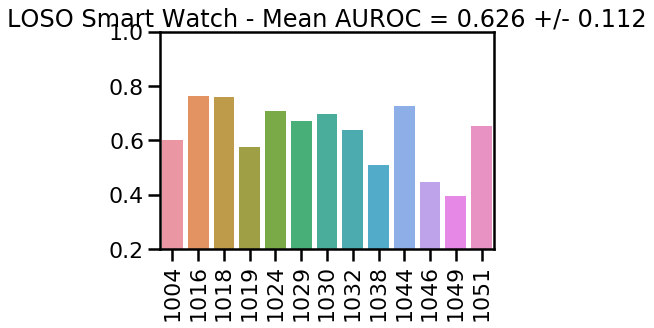

In [29]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaWatch.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Smart Watch - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaWatch.png',format='png',dpi=1000)

# Multiclass Comparisons

# Accelerometer and Gyroscope Comparisons

## Tremor

In [31]:
# filename = 'Features_AllLocsHP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'
# # Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Dataorig = Dataorig.reset_index(drop=True)

Dataorig = pd.read_csv('Accel+Gyro Data 62.5Hz.csv',index_col = 0)
# Dataorig.drop(columns=['Sen_X acc', 'Sen_Y acc', 'Sen_Z acc', 'Sen_mag acc', 'Sen_X gyr', 'Sen_Y gyr', 'Sen_Z gyr', 'Sen_mag gyr'], inplace=True)

Dataorig = Dataorig.reset_index(drop=True)

In [32]:
#LOSO Accelerometer Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:79].as_matrix()
fnames = Data.iloc[:,5:79].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Accel_Multi = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest

Subj/Visit 0,auroc=0.713

Subj/Visit 1,auroc=0.708

Subj/Visit 2,auroc=0.835

Subj/Visit 3,auroc=0.783

Subj/Visit 4,auroc=0.703

Subj/Visit 5,auroc=0.707

Subj/Visit 6,auroc=0.916

Subj/Visit 7,auroc=0.905

Subj/Visit 8,auroc=0.787

Subj/Visit 9,auroc=nan

Subj/Visit 10,auroc=0.336

Subj/Visit 11,auroc=0.722

Subj/Visit 12,auroc=0.720
auroc=0.736+/-0.141
Elapsed time = 1.356 min


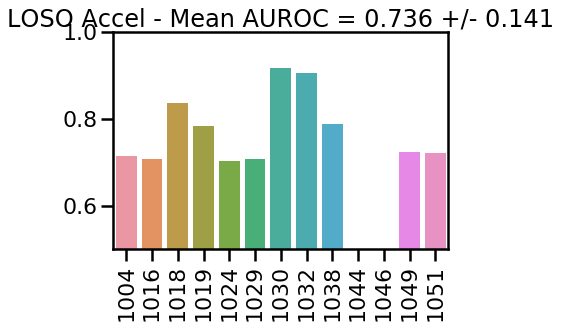

In [33]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOAccel_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.5,1.0])
plt.title('LOSO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOAccel_Hand.png',format='png',dpi=1000)

In [34]:
#LOSO Gyroscope Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,79:].as_matrix()
fnames = Data.iloc[:,79:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Gyro_Multi = res_group['Random Forest']

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest

Subj/Visit 0,auroc=0.713

Subj/Visit 1,auroc=0.800

Subj/Visit 2,auroc=0.777

Subj/Visit 3,auroc=0.772

Subj/Visit 4,auroc=0.687

Subj/Visit 5,auroc=0.733

Subj/Visit 6,auroc=0.937

Subj/Visit 7,auroc=0.914

Subj/Visit 8,auroc=0.784

Subj/Visit 9,auroc=nan

Subj/Visit 10,auroc=0.604

Subj/Visit 11,auroc=0.719

Subj/Visit 12,auroc=0.764
auroc=0.767+/-0.087
Elapsed time = 1.435 min


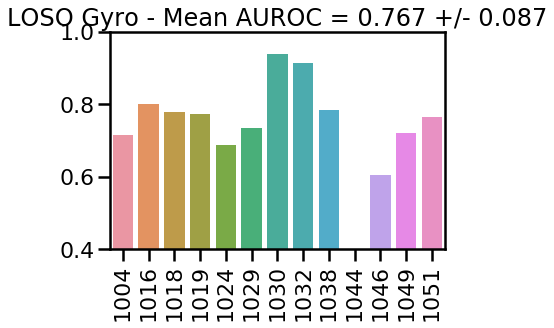

In [35]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOGyro_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.4,1.0])
plt.title('LOSO Gyro - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOGyro_Hand.png',format='png',dpi=1000)

In [36]:
#LOSO Combined Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
fnames = Data.iloc[:,5:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Comb_Multi = res_group['Random Forest']

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest

Subj/Visit 0,auroc=0.739

Subj/Visit 1,auroc=0.755

Subj/Visit 2,auroc=0.815

Subj/Visit 3,auroc=0.797

Subj/Visit 4,auroc=0.701

Subj/Visit 5,auroc=0.723

Subj/Visit 6,auroc=0.945

Subj/Visit 7,auroc=0.932

Subj/Visit 8,auroc=0.790

Subj/Visit 9,auroc=nan

Subj/Visit 10,auroc=0.445

Subj/Visit 11,auroc=0.736

Subj/Visit 12,auroc=0.683
auroc=0.755+/-0.123
Elapsed time = 2.112 min


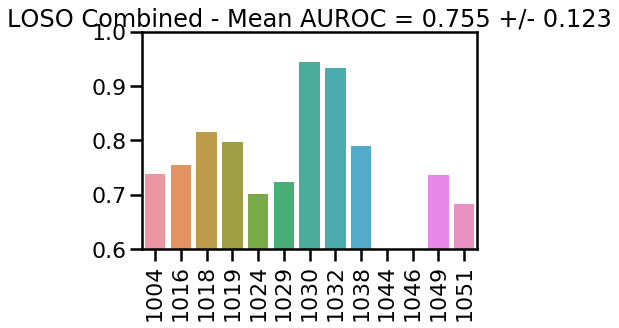

In [37]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOCombined_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.60,1.0])
plt.title('LOSO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOCombined_Hand.png',format='png',dpi=1000)

## Bradykinesia

In [39]:
# filename = 'Features_AllLocsHP+LP_Hand.pkl'
# features_path = r'Z:\CIS-PD Study\FeatureMatrix'
# Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
# Dataorig = Dataorig.reset_index(drop=True)

Dataorig = pd.read_csv('Accel+Gyro Data 62.5Hz.csv', index_col = 0)
# Dataorig.drop(columns=['Sen_X acc', 'Sen_Y acc', 'Sen_Z acc', 'Sen_mag acc', 'Sen_X gyr', 'Sen_Y gyr', 'Sen_Z gyr', 'Sen_mag gyr'], inplace=True)
Dataorig = Dataorig.reset_index(drop=True)

In [40]:
#LOSO Accelerometer Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:79].as_matrix()
fnames = Data.iloc[:,5:79].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Accel_Multi = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest

Subj/Visit 0,auroc=0.553

Subj/Visit 1,auroc=0.684

Subj/Visit 2,auroc=0.736

Subj/Visit 3,auroc=0.648

Subj/Visit 4,auroc=0.671

Subj/Visit 5,auroc=0.655

Subj/Visit 6,auroc=0.706

Subj/Visit 7,auroc=0.630

Subj/Visit 8,auroc=0.495

Subj/Visit 9,auroc=0.735

Subj/Visit 10,auroc=0.436

Subj/Visit 11,auroc=0.533

Subj/Visit 12,auroc=0.645
auroc=0.625+/-0.090
Elapsed time = 0.995 min


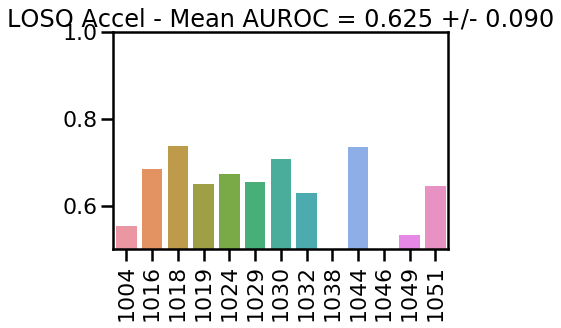

In [41]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOAccel_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.5,1.0])
plt.title('LOSO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOAccel_Hand.png',format='png',dpi=1000)

In [42]:
#LOSO Gyroscope Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,79:].as_matrix()
fnames = Data.iloc[:,79:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Gyro_Multi = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest

Subj/Visit 0,auroc=0.698

Subj/Visit 1,auroc=0.751

Subj/Visit 2,auroc=0.748

Subj/Visit 3,auroc=0.627

Subj/Visit 4,auroc=0.649

Subj/Visit 5,auroc=0.584

Subj/Visit 6,auroc=0.761

Subj/Visit 7,auroc=0.655

Subj/Visit 8,auroc=0.474

Subj/Visit 9,auroc=0.782

Subj/Visit 10,auroc=0.544

Subj/Visit 11,auroc=0.486

Subj/Visit 12,auroc=0.613
auroc=0.644+/-0.099
Elapsed time = 1.023 min


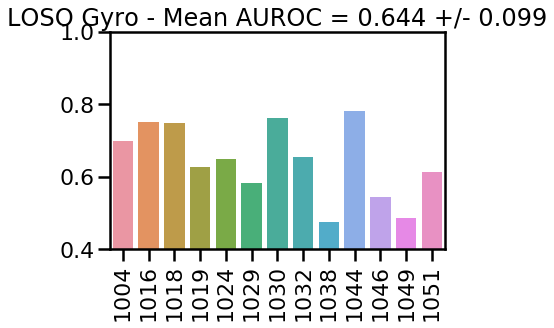

In [43]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOGyro_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.4,1.0])
plt.title('LOSO Gyro - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOGyro_Hand.png',format='png',dpi=1000)

In [44]:
#LOSO Combined Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
fnames = Data.iloc[:,5:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Comb_Multi = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest

Subj/Visit 0,auroc=0.715

Subj/Visit 1,auroc=0.699

Subj/Visit 2,auroc=0.756

Subj/Visit 3,auroc=0.622

Subj/Visit 4,auroc=0.692

Subj/Visit 5,auroc=0.633

Subj/Visit 6,auroc=0.772

Subj/Visit 7,auroc=0.602

Subj/Visit 8,auroc=0.479

Subj/Visit 9,auroc=0.812

Subj/Visit 10,auroc=0.501

Subj/Visit 11,auroc=0.513

Subj/Visit 12,auroc=0.652
auroc=0.650+/-0.102
Elapsed time = 1.489 min


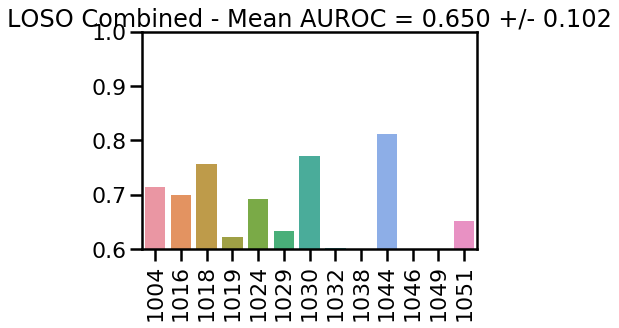

In [45]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOCombined_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.60,1.0])
plt.title('LOSO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOCombined_Hand.png',format='png',dpi=1000)

# Smartwatch

## Tremor

In [49]:
# Smart Watch

Dataorig = pd.read_csv('Watch Data 50Hz.csv',index_col=0)
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,5:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Trem_Watch_Multi = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest

Subj/Visit 0,auroc=0.718

Subj/Visit 1,auroc=0.795

Subj/Visit 2,auroc=0.857

Subj/Visit 3,auroc=0.787

Subj/Visit 4,auroc=0.752

Subj/Visit 5,auroc=0.728

Subj/Visit 6,auroc=0.977

Subj/Visit 7,auroc=0.945

Subj/Visit 8,auroc=0.768

Subj/Visit 9,auroc=nan

Subj/Visit 10,auroc=0.317

Subj/Visit 11,auroc=0.727

Subj/Visit 12,auroc=0.861
auroc=0.769+/-0.159
Elapsed time = 1.096 min


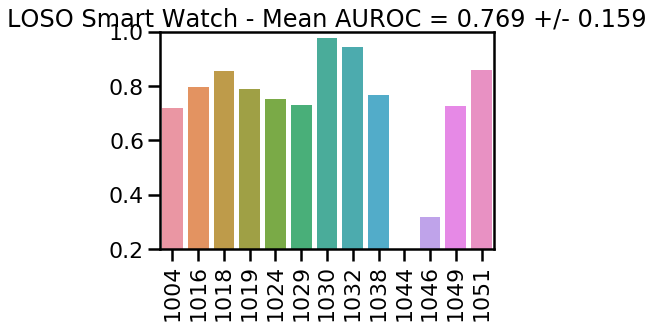

In [50]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorWatch.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Smart Watch - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorWatch.png',format='png',dpi=1000)

## Bradykinesia

In [54]:
#Smart Watch

Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data 50Hz.csv',index_col=0)
# Dataorig.drop(columns=['Sen_X', 'Sen_Y', 'Sen_Z', 'Sen_mag'], inplace=True)
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]
# Dataorig=Dataorig[Dataorig.Subject!=1030]

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,5:].columns.values

y = Data[symptom].values.astype(int) #target 
# print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV_Multi(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))

Brad_Watch_Multi = res_group['Random Forest']
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Random Forest

Subj/Visit 0,auroc=0.571

Subj/Visit 1,auroc=0.671

Subj/Visit 2,auroc=0.733

Subj/Visit 3,auroc=0.634

Subj/Visit 4,auroc=0.653

Subj/Visit 5,auroc=0.600

Subj/Visit 6,auroc=0.523

Subj/Visit 7,auroc=0.650

Subj/Visit 8,auroc=0.557

Subj/Visit 9,auroc=0.765

Subj/Visit 10,auroc=0.438

Subj/Visit 11,auroc=0.506

Subj/Visit 12,auroc=0.619
auroc=0.609+/-0.087
Elapsed time = 0.836 min


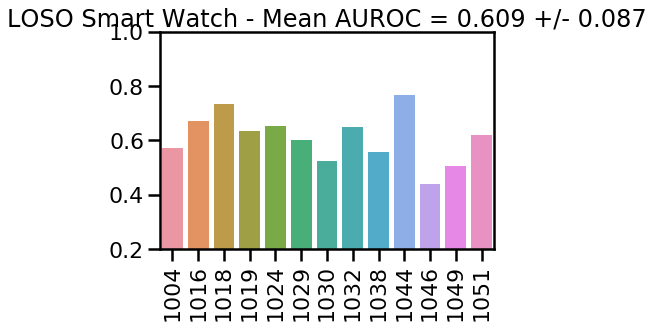

In [55]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaWatch.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Smart Watch - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaWatch.png',format='png',dpi=1000)

## Store Modeling Results

In [57]:
def pickleSave(filename,var):
    with open(filename,'wb') as handle:
        pickle.dump(var,handle)

In [58]:
files = ['Trem_Accel','Trem_Accel_Multi','Trem_Comb','Trem_Comb_Multi','Trem_Gyro','Trem_Gyro_Multi','Trem_Watch','Trem_Watch_Multi',
         'Brady_Accel','Brady_Accel_Multi','Brady_Comb','Brady_Comb_Multi','Brady_Gyro','Brady_Gyro_Multi','Brady_Watch','Brady_Watch_Multi']

In [59]:
varbs = [Trem_Accel,Trem_Accel_Multi,Trem_Comb,Trem_Comb_Multi,Trem_Gyro,Trem_Gyro_Multi,Trem_Watch,Trem_Watch_Multi,
         Brad_Accel,Brad_Accel_Multi,Brad_Comb,Brad_Comb_Multi,Brad_Gyro,Brad_Gyro_Multi,Brad_Watch,Brad_Watch_Multi]
for f,v in zip(files,varbs):
    print(f)
    pickleSave('Results\\'+f,v)

Trem_Accel
Trem_Accel_Multi
Trem_Comb
Trem_Comb_Multi
Trem_Gyro
Trem_Gyro_Multi
Trem_Watch
Trem_Watch_Multi
Brady_Accel
Brady_Accel_Multi
Brady_Comb
Brady_Comb_Multi
Brady_Gyro
Brady_Gyro_Multi
Brady_Watch
Brady_Watch_Multi


In [60]:
d = {}
for f in files:
    with open('Results\\'+f, 'rb') as handle:
        d[f] = pickle.load(handle)
    

## Make Figures w/ ROC Curves

### Tremor

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


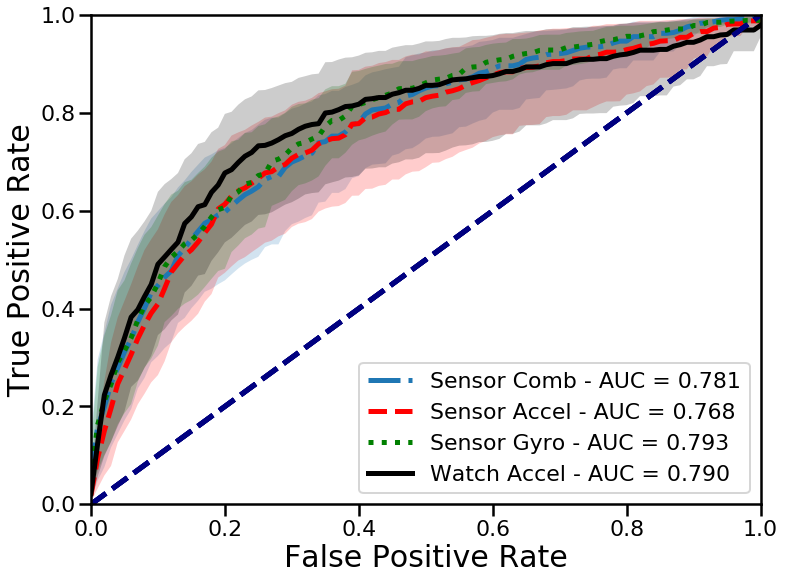

In [61]:
data = d['Trem_Comb']
plt.figure(figsize=(12,9))
lw = 5
ax = plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
             plotname='Sensor Comb',ls='-.',lw=5)
for data, c, name, ls in zip([d['Trem_Accel'],d['Trem_Gyro'],d['Trem_Watch']],['r','g','k'],
                         ['Sensor Accel','Sensor Gyro','Watch Accel'],['--',':','-']):
    plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
             plotname=name,ax = ax, col = c, ls = ls,lw=5)
ax.set_xlabel(ax.get_xlabel(), fontsize=30)
ax.set_ylabel(ax.get_ylabel(), fontsize=30)
plt.xlim(0,1)
plt.ylim(0,1)

plt.savefig('Images\\Hardware\\TremorBinary.svg')

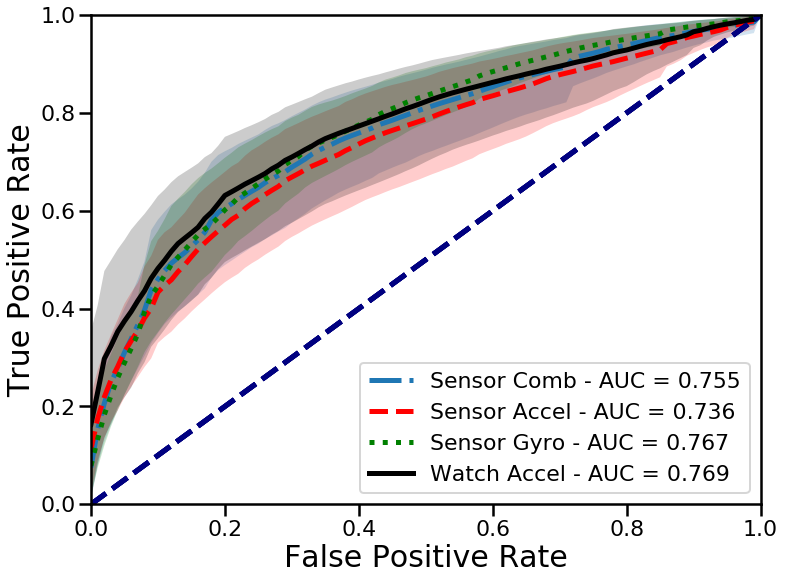

In [62]:
data = d['Trem_Comb_Multi']
plt.figure(figsize=(12,9))
ax = plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
              plotname='Sensor Comb',ls='-.',lw=lw)
for data, c, name, ls in zip([d['Trem_Accel_Multi'],d['Trem_Gyro_Multi'],d['Trem_Watch_Multi']],['r','g','k'],
                         ['Sensor Accel','Sensor Gyro','Watch Accel'],['--',':','-']):
    plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
             plotname=name,ax = ax, col = c,ls = ls,lw=lw)
    
ax.set_xlabel(ax.get_xlabel(), fontsize=30)
ax.set_ylabel(ax.get_ylabel(), fontsize=30)
plt.xlim(0,1)
plt.ylim(0,1)

plt.savefig('Images\\Hardware\\TremorMulti.svg')

### Bradykinesia

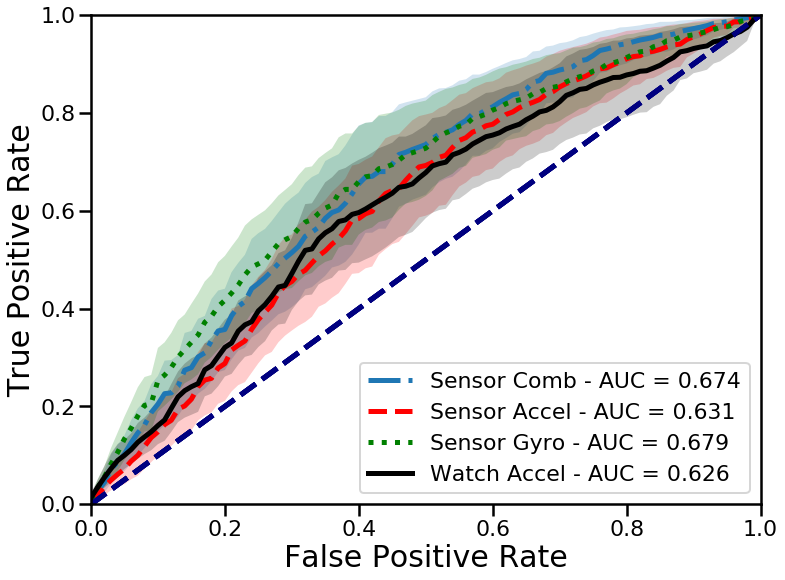

In [63]:
data = d['Brady_Comb']
plt.figure(figsize=(12,9))
ax = plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
              plotname='Sensor Comb',ls='-.',lw=lw)
for data, c, name, ls in zip([d['Brady_Accel'],d['Brady_Gyro'],d['Brady_Watch']],['r','g','k'],
                         ['Sensor Accel','Sensor Gyro','Watch Accel'],['--',':','-']):
    plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
             plotname=name,ax = ax, col = c, ls=ls,lw=lw)
    
ax.set_xlabel(ax.get_xlabel(), fontsize=30)
ax.set_ylabel(ax.get_ylabel(), fontsize=30)
plt.xlim(0,1)
plt.ylim(0,1)

plt.savefig('Hardware\\BradyBinary.svg')

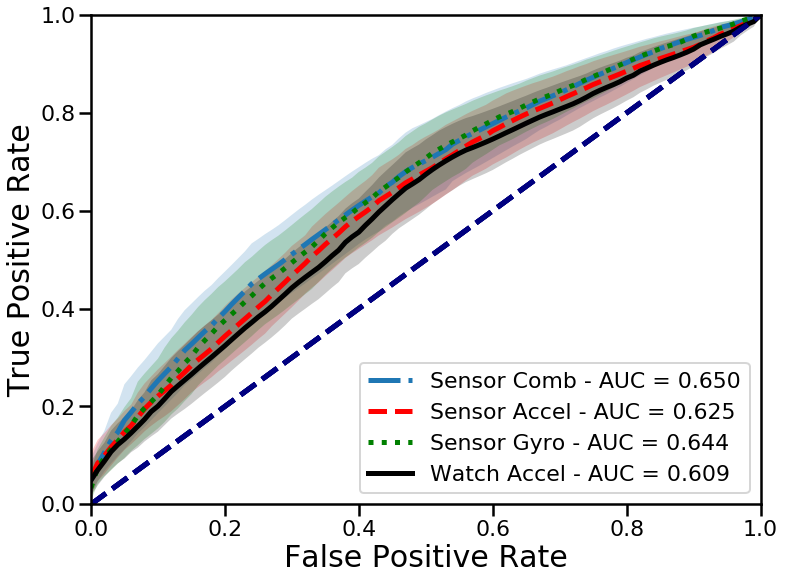

In [64]:
data = d['Brady_Comb_Multi']
plt.figure(figsize=(12,9))
ax = plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
              plotname='Sensor Comb',ls='-.',lw=lw)
for data, c, name, ls in zip([d['Brady_Accel_Multi'],d['Brady_Gyro_Multi'],d['Brady_Watch_Multi']],['r','g','k'],
                         ['Sensor Accel','Sensor Gyro','Watch Accel'],['--',':','-']):
    plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']), 
             plotname = name, ax = ax, col = c,ls = ls,lw=lw)

ax.set_xlabel(ax.get_xlabel(), fontsize=30)
ax.set_ylabel(ax.get_ylabel(), fontsize=30)
plt.xlim(0,1)
plt.ylim(0,1)

plt.savefig('Images\\Hardware\\BradyMulticlass.svg')

## Compare results

In [65]:
def PairedT(A,B):
    A = np.array(A); B = np.array(B)
    inds = np.isnan(A) | np.isnan(B)
    inds = np.array(~inds)
    return ttest_rel(A[inds],B[inds])

In [66]:
print(PairedT(d['Trem_Comb']['auroc'],d['Trem_Accel']['auroc']))
print(PairedT(d['Trem_Comb']['auroc'],d['Trem_Gyro']['auroc']))
print(PairedT(d['Trem_Comb']['auroc'],d['Trem_Watch']['auroc']))

Ttest_relResult(statistic=0.8030356670654883, pvalue=0.43896134158826505)
Ttest_relResult(statistic=-0.7118122617544989, pvalue=0.4914017986242948)
Ttest_relResult(statistic=-0.5174125486966432, pvalue=0.615113518289163)


In [76]:
for v, f in zip(varbs,files):
    v = v['auroc']
    print('%s -  %.2f (%.2f-%.2f)'%(f+' '*(18-len(f)),np.nanmean(v),np.nanmean(v)-1.96*stats.sem(v,nan_policy='omit'),np.nanmean(v)+1.96*stats.sem(v,nan_policy='omit')))

Trem_Accel         -  0.77 (0.67-0.87)
Trem_Accel_Multi   -  0.74 (0.65-0.82)
Trem_Comb          -  0.78 (0.70-0.86)
Trem_Comb_Multi    -  0.76 (0.68-0.83)
Trem_Gyro          -  0.79 (0.74-0.85)
Trem_Gyro_Multi    -  0.77 (0.72-0.82)
Trem_Watch         -  0.79 (0.69-0.89)
Trem_Watch_Multi   -  0.77 (0.68-0.86)
Brady_Accel        -  0.63 (0.57-0.70)
Brady_Accel_Multi  -  0.63 (0.57-0.68)
Brady_Comb         -  0.67 (0.61-0.74)
Brady_Comb_Multi   -  0.65 (0.59-0.71)
Brady_Gyro         -  0.68 (0.61-0.75)
Brady_Gyro_Multi   -  0.64 (0.59-0.70)
Brady_Watch        -  0.63 (0.56-0.69)
Brady_Watch_Multi  -  0.61 (0.56-0.66)


In [68]:
def rmANOVA(df,columns):
    grand_mean = np.mean(df[columns].mean())
    sub_means = np.mean(df[columns],axis=1)
    col_means = np.mean(df[columns],axis=0)
    n = len(df)
    k = len(columns)
    dftotal = n*k - 1
    dfbw = k - 1
    dfsbj = n - 1
    dfw = dftotal - dfbw
    dferror = dfw - dfsbj
    SSbetween = sum(n*[(m-grand_mean)**2 for m in col_means])
    SSwithin = np.nansum(np.nansum([(df[col] - col_means[i])**2 for i,col in enumerate(df[columns])]))
    SSsubject = sum(k*[(m - grand_mean)**2 for m in sub_means])
    SSerror = SSwithin - SSsubject
    SStotal = SSbetween + SSwithin
    msbetween = SSbetween/dfbw
    mserror = SSerror/dferror
    F = msbetween/mserror
    return F,stats.f.sf(F,dfbw,dferror)

In [69]:
def HBCorrections(vs,fs,d,target=.05):
    res = []
    for pair in itertools.combinations([(d[v]['auroc'],f) for v,f in zip(vs,fs)],2):
        f_pair = [pair[0][1],pair[1][1]]
        if (fs[0] not in f_pair) and ((fs[1] not in f_pair) or fs[3] not in f_pair):
            continue
        p = PairedT(pair[0][0], pair[1][0])[1]
        res.append((p,pair[0][1]+'+'+pair[1][1]))
    
    res = sorted(res)
    dec = 'Reject'
    for r,i in zip(res,range(1,len(res)+1)):
        thresh = target/(len(res)-i+1)
        if r[0]<thresh and dec=='Reject':
            dec = 'Reject'
        else:
            dec = 'Accept'
        print('%s\t%.3f\t%.3f\t%s'%(r[1],r[0]/2,thresh,dec))

In [70]:
vs, fs = ['Trem_Comb', 'Trem_Accel', 'Trem_Gyro', 'Trem_Watch'], ['Trem_Combo', 'Trem_Accel', 'Trem_Gyro', 'Trem_Watch']
df = pd.DataFrame(data = np.vstack([d[v]['auroc'] for v in vs]).transpose(), columns = fs).dropna()
rmANOVA(df,fs)

(0.5712141427508696, 0.63792965574609)

In [71]:
vs, fs = ['Trem_Comb_Multi', 'Trem_Accel_Multi', 'Trem_Gyro_Multi', 'Trem_Watch_Multi'], ['Trem_Combo_Multi', 'Trem_Accel_Multi', 'Trem_Gyro_Multi', 'Trem_Watch_Multi']
df = pd.DataFrame(data = np.vstack([d[v]['auroc'] for v in vs]).transpose(), columns = fs).dropna()
rmANOVA(df,fs)

(1.1718411115278522, 0.3352918246171233)

In [72]:
vs, fs = ['Brady_Comb', 'Brady_Accel', 'Brady_Gyro', 'Brady_Watch'], ['Brad_Combo', 'Brad_Accel', 'Brad_Gyro', 'Brad_Watch']
df = pd.DataFrame(data = np.vstack([d[v]['auroc'] for v in vs]).transpose(), columns = fs).dropna()
rmANOVA(df,fs)

(4.9800776920468115, 0.005424056848373397)

In [73]:
HBCorrections(vs,fs,d)

Brad_Combo+Brad_Watch	0.001	0.013	Reject
Brad_Combo+Brad_Accel	0.007	0.017	Reject
Brad_Combo+Brad_Gyro	0.382	0.025	Accept
Brad_Accel+Brad_Watch	0.393	0.050	Accept


In [74]:
vs, fs = (['Brady_Comb_Multi', 'Brady_Accel_Multi', 'Brady_Gyro_Multi', 'Brady_Watch_Multi'], 
          ['Brad_Combo_Multi', 'Brad_Accel_Multi', 'Brad_Gyro_Multi', 'Brad_Watch_Multi'])
df = pd.DataFrame(data = np.vstack([d[v]['auroc'] for v in vs]).transpose(), columns = fs).dropna()
rmANOVA(df,fs)

(2.0960491594726776, 0.11790081582533013)

In [75]:
HBCorrections(vs,fs,d)

Brad_Combo_Multi+Brad_Watch_Multi	0.050	0.013	Accept
Brad_Combo_Multi+Brad_Accel_Multi	0.066	0.017	Accept
Brad_Accel_Multi+Brad_Watch_Multi	0.174	0.025	Accept
Brad_Combo_Multi+Brad_Gyro_Multi	0.281	0.050	Accept
